<a href="https://colab.research.google.com/github/HugoKD/Abalone_projet/blob/master/some_model%26cool_visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import statistics as stat
import math

Rq : La matrice de covariance représente la manière dont les différentes dimensions sont corrélées entre elles et doit respecter certaines propriétés mathématiques.

##A labeled Data Set


In [103]:
from scipy.stats import multivariate_normal

mu_1 = np.array([2.5,2.5])
sigma_1 = np.array([[2,-0.8],[-0.8,2]])

mu_0 = np.array([0,0])
sigma_0 = np.array([[1,0],[0,1]])

In [104]:
X1 = multivariate_normal(mu_1, sigma_1) #or np.random.multivariate_normal(mean,var,n_sample)
X0 = multivariate_normal(mu_0, sigma_0) #or np.random.multivariate_normal(mean,var,n_sample)

num_sample_1 = 100
num_sample_0 = 200
x1 = X1.rvs(size=num_sample_1)
x0 = X0.rvs(size=num_sample_0)

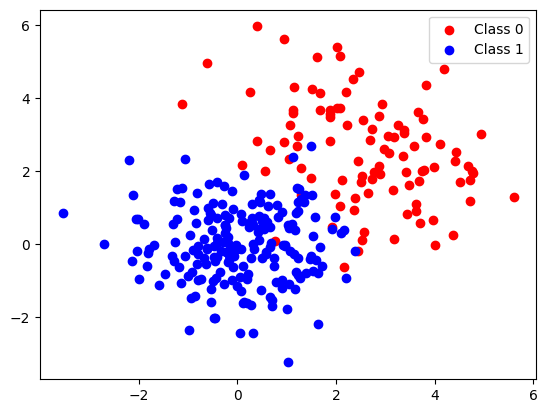

In [105]:
plt.scatter(x1[:, 0], x1[:, 1], c='red', label='Class 0')
plt.scatter(x0[:, 0], x0[:, 1], c='blue', label='Class 1')
plt.legend()

In [106]:
#vérif si la moyenne est proche de l'esp
import pandas as pd
df = pd.DataFrame(np.random.multivariate_normal(mu_1, sigma_1, 100))

x_mean, y_mean = 0,0
df.apply(lambda x : (x_mean+x[0])/len(df))
df.apply(lambda x : (y_mean+x[1])/len(df))

,0
0,-0.008587
1,0.036508


In [107]:
y = np.array([1]*len(x1)+[0]*len(x0))
X = np.concatenate((x1,x0))

##A first model of machine learning. The naive Bayes model

### Model from scratch

**Idée de l'exercice**
<br>

Une des problématiques majeures en statistique consiste à connaître la distribution sous-jacente des données. Ici, nous savons que cette distribution est multivariée. Cependant, dans un contexte réel, on pourrait simplement poser l’hypothèse que la distribution initiale est effectivement multivariée. L’objectif serait alors d’estimer les paramètres de cette distribution à l’aide de méthodes comme le maximum de vraisemblance ou l’algorithme EM. <br>

Dans cet exercice, nous disposons d’une base de données non annotée provenant de deux sources distinctes. Le but est donc de réussir à labelliser ces données à partir des informations brutes. La première partie, dite "Stat", consiste à formuler les bonnes hypothèses et à estimer les paramètres de la distribution. Cette étape est supposée être déjà accomplie. Notre travail se concentre sur la deuxième partie, qui consiste à réaliser l’annotation à partir des données brutes.



In [108]:
#nos informations initiales

prior_p_1 = num_sample_1/(num_sample_1+num_sample_0)
prior_p_0 = num_sample_0/(num_sample_1+num_sample_0)


#On suppose que nos distri sont des gaussiennes, qu'il y en a deux, indépendantes. Maintenant, il faut déterminer quels data point appartient à quelle classe. => max de vraissemblance
#On créer nos données


likelihood_1 = np.array([X1.pdf(X[i]) for i in range(len(x1))] + [X0.pdf(X[i]) for i in range(len(x0))])
likelihood_0 = np.array([X0.pdf(X[i]) for i in range(len(x0))] + [X1.pdf(X[i]) for i in range(len(x1))])

Cf formule de Bayes:

$$
P(C_1|X) = \frac{P(X|C_1) \cdot P(C_1)}{P(X)}
$$
<br>
Alors, $$ C=argmax(P(Ci​∣x)) $$


In [109]:
prior_p_1 = num_sample_1 / (num_sample_1 + num_sample_0)
prior_p_0 = num_sample_0 / (num_sample_1 + num_sample_0)

def calculate_likelihoods(x, dist):
    return np.array([dist.pdf(xi) for xi in x])

likelihood_x0_0 = calculate_likelihoods(x0, X0)  # P(X0 | classe 0)
likelihood_x0_1 = calculate_likelihoods(x0, X1)  # P(X0 | classe 1)
likelihood_x1_0 = calculate_likelihoods(x1, X0)
likelihood_x1_1 = calculate_likelihoods(x1, X1)

M_bool_0 = likelihood_x0_0 > likelihood_x0_1  # Classe 0 vs Classe 1 pour x0
M_bool_1 = likelihood_x1_1 > likelihood_x1_0

print('Avec la méthode du maximum de vraisemblance, nous avons mal classifié :',
      len(M_bool_0) - M_bool_0.sum(), 'point(s) dans x0')
print('Avec la méthode du maximum de vraisemblance, nous avons mal classifié :',
      len(M_bool_1) - M_bool_1.sum(), 'point(s) dans x1')

def calculate_posteriors(prior, likelihood, other_prior, other_likelihood):
    return (prior * likelihood) / (prior * likelihood + other_prior * other_likelihood)

posterior_x0_0 = calculate_posteriors(prior_p_0, likelihood_x0_0, prior_p_1, likelihood_x0_1)
posterior_x0_1 = calculate_posteriors(prior_p_1, likelihood_x0_1, prior_p_0, likelihood_x0_0)

posterior_x1_0 = calculate_posteriors(prior_p_0, likelihood_x1_0, prior_p_1, likelihood_x1_1)
posterior_x1_1 = calculate_posteriors(prior_p_1, likelihood_x1_1, prior_p_0, likelihood_x1_0)

def predict_class(posterior_class_0, posterior_class_1):
    return np.where(posterior_class_1 > posterior_class_0, 1, 0)  # 1 si classe 1, sinon 0

class_X0 = predict_class(posterior_x0_0, posterior_x0_1)
class_X1 = predict_class(posterior_x1_0, posterior_x1_1)


#sorted0, l'ensemble des points qui ont été classé appartenant à la classe 0 (vrai ou pas)

sorted0 = [x0[i] for i in range(len(class_X0)) if class_X0[i] == 0] + [x1[i] for i in range(len(class_X1)) if class_X1[i] == 0]
sorted1 = [x0[i] for i in range(len(class_X0)) if class_X0[i] == 1] + [x1[i] for i in range(len(class_X1)) if class_X1[i] == 1]

Avec la méthode du maximum de vraisemblance, nous avons mal classifié : 9 point(s) dans x0
Avec la méthode du maximum de vraisemblance, nous avons mal classifié : 5 point(s) dans x1


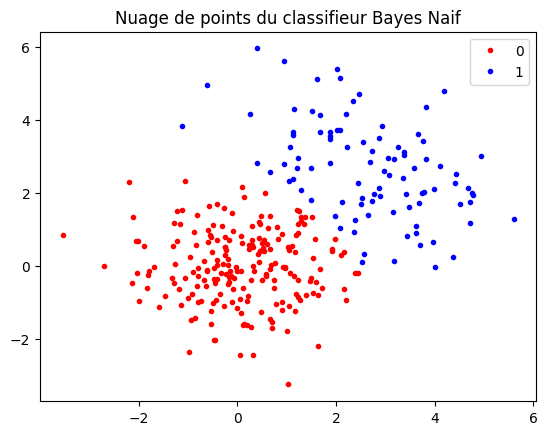

In [110]:
plt.plot([sorted0[i][0] for i in range(len(sorted0))], [sorted0[i][1] for i in range(len(sorted0))], color='red', marker='.', linestyle='None', label='0')
plt.plot([sorted1[i][0] for i in range(len(sorted1))], [sorted1[i][1] for i in range(len(sorted1))], color='blue', marker='.', linestyle='None', label='1')
plt.legend()
plt.title("Nuage de points du classifieur Bayes Naif")
plt.show()

Rq : Pb lineaire si la matrice de covariance entre les deux classes sont identiques (Cf cours Poly, LDA vs GDA)

###Evaluation of the model

In [111]:
# Négatif = 0
# Positif = 1

In [112]:
nbr_error =0
false_positive = 0
false_negative = 0

for i in range(len(sorted0)):
  if sorted0[i] not in x0:
    nbr_error+=1
    false_negative+=1

for i in range(len(sorted1)):
  if sorted1[i] not in x1:
    nbr_error+=1
    false_positive+=1

In [113]:
print('Le nombre de faux négatifs est :'  + str(false_negative) + ' et le nombre de faux positifs est :' + str(false_positive) + ' le tout pour un nombre d\'erreurs totales de :' + str(nbr_error))

Le nombre de faux négatifs est :7 et le nombre de faux positifs est :2 le tout pour un nombre d'erreurs totales de :9


In [114]:
#Accuracy, Precision, recall and F1-score TODO

###Représentation de la boundary

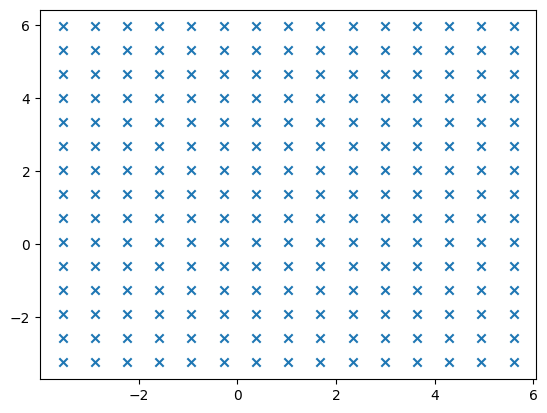

In [115]:
x_min, x_max = min(x1[:, 0].min(), x0[:, 0].min()), max(x1[:, 0].max(), x0[:, 0].max())
y_min, y_max = min(x1[:, 1].min(), x0[:, 1].min()), max(x1[:, 1].max(), x0[:, 1].max())

N = 15

hor = np.linspace(start = x_min, stop = x_max, num = N)
ver = np.linspace(start = y_min, stop = y_max, num = N)

x1Eval,x2Eval = np.meshgrid(hor,ver)
plt.scatter(x1Eval, x2Eval, marker='x')

In [116]:
xy_points = np.c_[x1Eval.ravel(), x2Eval.ravel()] #N*N points
predicted_class = np.zeros(xy_points.shape[0])

In [117]:
for i, point in enumerate(xy_points): # The decision if a point belong to a class i done by calculating the norm of the closest point to this one

    dist_to_class0 = np.linalg.norm(sorted0 - point, axis=1).min()
    dist_to_class1 = np.linalg.norm(sorted1 - point, axis=1).min()

    if dist_to_class0 < dist_to_class1:
        predicted_class[i] = 0
    else:
        predicted_class[i] = 1

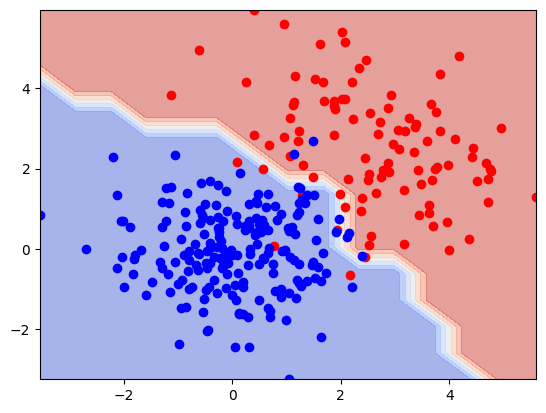

In [118]:
plt.contourf(hor, ver, predicted_class.reshape(x1Eval.shape), alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(x1[:, 0], x1[:, 1], c='red', label='Class 0')
plt.scatter(x0[:, 0], x0[:, 1], c='blue', label='Class 1')

### With Scikit learn



*   Comme d'hab, on suppose l'indépendance des données
*   Ici, par le choix de l'import, on fait aussi l'assumption que nos données viennent d'une gaussienne (pour chaque classe)



In [119]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report

gnb = GaussianNB();
X = np.concatenate((x0,x1))
y = np.concatenate((np.zeros(len(x0)),np.ones(len(x1))))
gnbfit=gnb.fit(X, y);
y_pred = gnbfit.predict(X)

In [120]:
accuracy = accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred)
print(accuracy)
print(class_report)

0.97
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       200
         1.0       0.98      0.93      0.95       100

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



In [121]:
gnbfit.class_count_,gnbfit.class_prior_,gnbfit.classes_,gnbfit.theta_,gnbfit.var_

(array([200., 100.]),
 array([0.66666667, 0.33333333]),
 array([0., 1.]),
 array([[ 0.0395236 , -0.01395897],
        [ 2.59855513,  2.531209  ]]),
 array([[1.08688053, 1.00547938],
        [1.72211674, 1.95350925]]))

**Donc ici c'est plus fort que précédemment. On ne connaissait pas les paramètres de nos gaussiennes !**

####ROC Curve

The AUC (Area Under the Curve) is an important performance metric used in classification tasks, especially for binary classifiers. It refers to the Area Under the Receiver Operating Characteristic (ROC) Curve. The AUC-ROC metric evaluates how well a binary classifier can distinguish between the two classes (positive and negative).

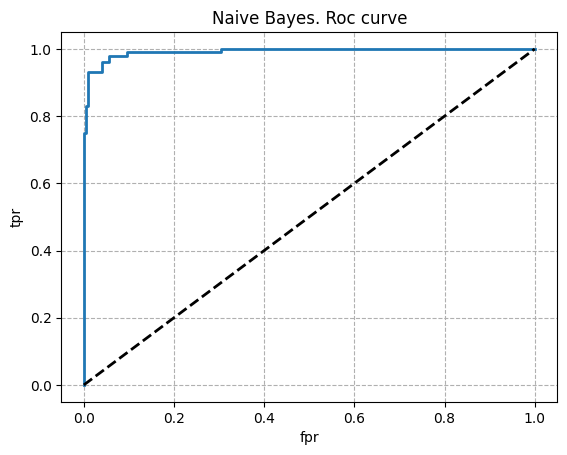

In [122]:
from sklearn.metrics import roc_curve, auc,roc_auc_score


y_proba = gnbfit.predict_proba(X)[:,1]; #we take the proba that x belong to class 1 (1 - p(X E class 0))
fpr, tpr, thresholds = roc_curve(y, y_proba);
plt.plot(fpr,tpr, linewidth = 2);
plt.title('Naive Bayes. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth = 2);
plt.grid(linestyle = 'dashed'); plt.show();

Interpretation of AUC:
<br><br>
AUC = 1.0: This means the classifier is perfect. It ranks all positive instances higher than negative ones, perfectly distinguishing between the two classes. <br>
AUC = 0.5: This indicates the classifier has no discriminatory power and is performing no better than random guessing.<br>
AUC < 0.5: This means the classifier is worse than random, as it misclassifies more than it gets right. However, this situation is rare.<br><br>
0.7 ≤ AUC < 0.8: Acceptable or fair performance.<br>
0.8 ≤ AUC < 0.9: Good performance.<br>
0.9 ≤ AUC ≤ 1: Excellent or outstanding performance.<br>

In [123]:
auc = roc_auc_score(y, y_proba)
print(auc)

0.9923000000000001


###CV

In [124]:
## Pipeline pour plus de concision

In [125]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

gnb = GaussianNB()
pipe = Pipeline([('classifier', gnb)])

cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
print(cv_scores)

[0.98333333 0.93333333 1.         0.95       0.98333333]


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=1/3, random_state=0)
gnb = GaussianNB()
gnbfit=gnb.fit(X_train, y_train)
accuracy_score(gnbfit.predict(X_test),y_test)

0.97

## Other model (LDA,QDA, Logistic Reg, KNN) & Visualisation

Pour un problème à deux classes, LDA ne peut produire qu'un seul axe discriminant (une seule composante). Autrement dit, n_components doit être 1, car c'est la limite maximale.

In [127]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline

In [135]:
#For visualisation

X_horiz_max, X_horiz_min = np.max(X[:, 0]), np.min(X[:, 0])
X_vertic_max, X_vertic_min = np.max(X[:, 1]), np.min(X[:, 1])

points_horiz = np.linspace(start=X_horiz_min,
                      stop=X_horiz_max,
                     num=100)

point_vertic = np.linspace(start=X_vertic_min,
                      stop=X_vertic_max,
                     num=100)

x1Eval, x2Eval = np.meshgrid(points_horiz, point_vertic)

In [136]:
%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #All cov matrix are equal
from sklearn.naive_bayes import GaussianNB


lda = LinearDiscriminantAnalysis(n_components=1)

pipe = Pipeline([('classifier', lda)])

cv_scores = cross_val_score(pipe, X, y, cv=100, scoring='accuracy').mean()

model_lda = pipe.fit(X,y)
print(cv_scores)

0.9633333333333333
CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 317 ms


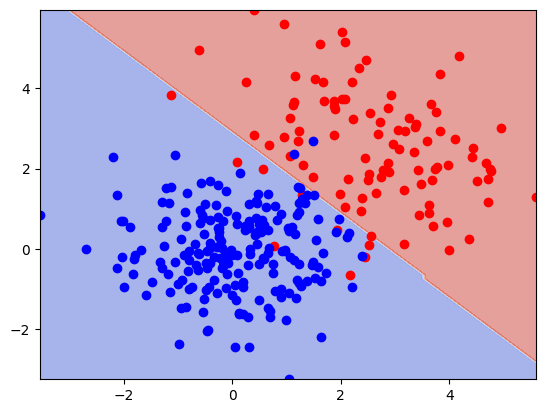

In [137]:
z_value = model_lda.predict(np.c_[x1Eval.ravel(), x2Eval.ravel()])
z_value = z_value.reshape(x1Eval.shape)

plt.contourf(x1Eval, x2Eval, z_value, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(x1[:, 0], x1[:, 1], c='red', label='Class 0')
plt.scatter(x0[:, 0], x0[:, 1], c='blue', label='Class 1')

In [129]:
%%time

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis ##All cov matrix are equal

qda = QuadraticDiscriminantAnalysis()
pipe = Pipeline([('classifier', qda)])

cv_scores = cross_val_score(pipe, X, y, cv=100, scoring='accuracy').mean()

model_qda = pipe.fit(X,y)
print(cv_scores) #Better results but (n-1) parameters more (covariance)

0.9666666666666666
CPU times: user 294 ms, sys: 4.92 ms, total: 299 ms
Wall time: 305 ms


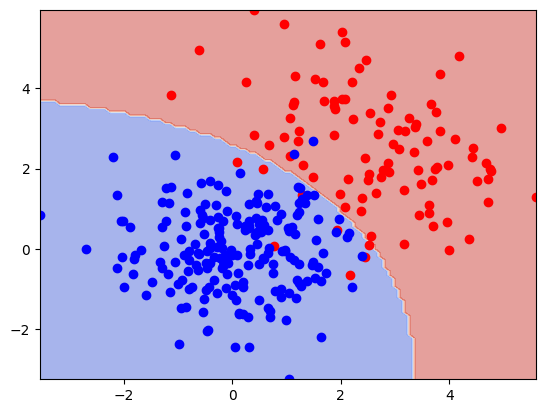

In [138]:
z_value = model_qda.predict(np.c_[x1Eval.ravel(), x2Eval.ravel()])
z_value = z_value.reshape(x1Eval.shape)

plt.contourf(x1Eval, x2Eval, z_value, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(x1[:, 0], x1[:, 1], c='red', label='Class 0')
plt.scatter(x0[:, 0], x0[:, 1], c='blue', label='Class 1')

In [130]:
%%time

from sklearn import linear_model


logreg = linear_model.LogisticRegression(C=1e5)

pipe = Pipeline([('classifier', logreg)])

cv_scores = cross_val_score(pipe, X, y, cv=100, scoring='accuracy').mean()
model_logreg = pipe.fit(X, y)

print(f'Mean cross-validation score: {cv_scores:.4f}')

Mean cross-validation score: 0.9467
CPU times: user 602 ms, sys: 6.02 ms, total: 608 ms
Wall time: 625 ms


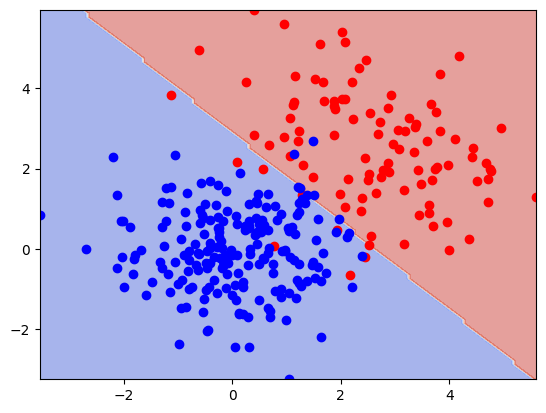

In [141]:
z_value = model_logreg.predict(np.c_[x1Eval.ravel(), x2Eval.ravel()])
z_value = z_value.reshape(x1Eval.shape)

plt.contourf(x1Eval, x2Eval, z_value, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(x1[:, 0], x1[:, 1], c='red', label='Class 0')
plt.scatter(x0[:, 0], x0[:, 1], c='blue', label='Class 1')

In [131]:
%%time

from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'classifier__n_neighbors': [2, 3, 4, 5, 6,7, 10, 20],
}

knn = KNeighborsClassifier()

pipe = Pipeline([('classifier', knn)])
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

model_knn = grid_search.fit(X, y)
print(model_knn.best_params_)

cv_scores = model_knn.best_score_

print(f"Meilleur score de cross-validation: {cv_scores:.4f}")

{'classifier__n_neighbors': 3}
Meilleur score de cross-validation: 0.9633
CPU times: user 57.6 ms, sys: 5.9 ms, total: 63.5 ms
Wall time: 288 ms


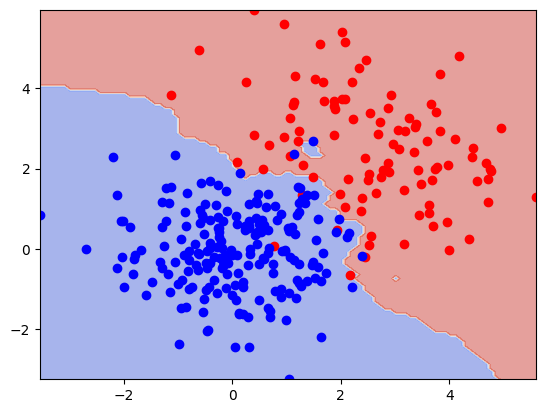

In [142]:
z_value = model_knn.predict(np.c_[x1Eval.ravel(), x2Eval.ravel()])
z_value = z_value.reshape(x1Eval.shape)

plt.contourf(x1Eval, x2Eval, z_value, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(x1[:, 0], x1[:, 1], c='red', label='Class 0')
plt.scatter(x0[:, 0], x0[:, 1], c='blue', label='Class 1')

##How to choose an appropriate classifier ? The evaluation criteria

##Annexe

book : A probabilistic approach of Machine Learning, Murphy